In [1]:
#in this notebook we're going to write all of the data processing steps of our pipeline
#Inputs - Alignments with associated PDB files

#Outputs - X: fourier transfor of 3d matrix of prot features. possible distmat of potts model
#Y: distmat of 3d fold (biopython), protein class(from SCOP or CATH) ,torsion angles, ss , solvent access ( DSSP )

#### Imports

In [1]:
import os
import glob
import sys
#import wget
import time
import subprocess
import shlex
import sys
import warnings
import random
import pickle

from Bio.SeqUtils import seq1
from Bio.PDB.PDBParser import PDBParser
from Bio import AlignIO

from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler,  Normalizer , MinMaxScaler , RobustScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

'''import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ResourceProfiler, Profiler, ProgressBar

from dask_ml.preprocessing import RobustScaler
from dask_ml.decomposition import IncrementalPCA'''

#not used for now
from sklearn.pipeline import make_pipeline

sys.path.append('./ProFET/ProFET/feat_extract/')
import FeatureGen

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import h5py

#### Class definitions

In [2]:
#PCA and scaler
class NDSRobust(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = RobustScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self
    
    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X
    
    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

#ndimensional PCA for arrays

class NDSPCA(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = IncrementalPCA(copy = True, **kwargs)
        self._orig_shape = None
    
    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        self.explained_variance_ratio_ = self._scaler.explained_variance_ratio_
        self.components_ =self._scaler.components_
        
        return self
    
    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X
    
    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

#### Function definitions
##### PCA and scaler

In [3]:
#DEFAULT VALUES
#how many components to keep after PCA?
components = 300
#minibatch size for incremental PCA/Scaling?
batch_size = 100

#fit the components of the output space
#y: array of stacked distmats (on the 1st axis)
def fit_y( y, components = components,  batch_size = batch_size, FFT = True ):
    if FFT == True:
        #got through a stack of structural distmats. these should be 0 padded to all fit in an array
        
        y = np.stack([ np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])] )
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
    print(y.shape)
    ndpca = NDSPCA(n_components=components)
    
    #https://stackoverflow.com/questions/44334950/how-to-use-sklearns-incrementalpca-partial-fit
    
    '''nb_rows = y.shape[0]
    #check if // doesn't cause loss of data
    for i in range(0, nb_rows//batch_size):
        ndpca.partial_fit(y[i*batch_size : (i+1)*batch_size, :, :])
    
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))'''
       
    ndpca.fit(y)
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))
    
    scaler0 = NDSRobust()
    scaler0.fit(y)

    return ndpca, scaler0

def transform_y(y, scaler0, ndpca,  batch_size = batch_size, FFT = False):
    if FFT == True:
        y = np.stack([np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])])
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
        
    '''nb_rows = y.shape[0]
    #todo - change this shape to make sense
    out = da.zeros((components, y.shape[1], y.shape[2])) #array to contain components
    for i in range(0, nb_rows//batch_size):
        out[i*chunk_size : (i+1)*batch_size,:,:] = ndpca.transform(y[i*batch_size : (i+1)*batch_size,:,:]) '''   
    
    y = ndpca.transform(y)
    scaler0 = NDSRobust()
    scaler0.fit(y)
    y = scaler0.transform(y)
    print(y.shape)
    
    '''out = scaler0.transform(out)'''
    
    return y, scaler0

def inverse_transform_y(y, scaler0, ndpca, FFT=False):
    y = scaler0.inverse_transform(y)
    y = ndpca.inverse_transform(y)
    
    if FFT == True:
        split = int(y.shape[1]/2)
        y = np.stack([ np.fft.irfft2(y[i,:split,:] + 1j*y[i,split:,:]) for i in range(y.shape[0]) ] )
        
    return y

#fit the components of the in space
#stacked align voxels (on the 1st axis)
def fit_x(x, components = components,  batch_size = batch_size, FFT = True):
    if FFT == True:
        #got through a stack of align voxels. these should be 0 padded to all fit in an array
        
        x = np.stack([ np.fft.rfftn(x[i,:,:,:]) for i in range(x.shape[0])] )
        print(x.shape)
        x =  np.hstack( [ np.real(x) , np.imag(x)]  )
    print(x.shape)
    ndpca = NDSPCA(n_components=components)
    
    '''nb_rows = x.shape[0]
    #check if // doesn't cause loss of data
    for i in range(0, nb_rows//batch_size):
        ndpca.partial_fit(x[i*batch_size : (i+1)*batch_size,:,:,:])
    
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))'''
    
    ndpca.fit(x)
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))
    
    scaler0 = NDSRobust()
    scaler0.fit(x)
    
    return ndpca, scaler0

def transform_x(x, scaler0, ndpca, batch_size = batch_size, FFT = False):
    if FFT == True:
        x = np.stack([ np.fft.rfftn(x[i,:,:,:]) for i in range(x.shape[0])] )
        print(x.shape)
        x =  np.hstack( [ np.real(x) , np.imag(x)]  )
    
    '''#todo - change this shape to make sense
    out = da.zeros((components, x.shape[1], x.shape[2], x.shape[3])) #array to contain components
    nb_rows = x.shape[0]
    for i in range(0, nb_rows//batch_size):
        out[i*batch_size : (i+1)*batch_size,:,:,:] = ndpca.transform(x[i*batch_size : (i+1)*batch_size,:,:,:])
        
    out = scaler0.transform(out)'''

    x = ndpca.transform(x)
    scaler0 = NDSRobust()
    scaler0.fit(x)
    x = scaler0.transform(x)
    print(x.shape)
    
    return x, scaler0

#todo -- check the split is happening in the right dimension
def inverse_transform_x(x, scaler0, ndpca, FFT=False):
    x = scaler0.inverse_transform(x)
    x = ndpca.inverse_transform(x)
    
    if FFT == True:
        split = int(x.shape[1]/2)
        x = np.stack([ np.fft.irfftn(x[i,:split,:,:] + 1j*x[i,split:,:,:]) for i in range(x.shape[0]) ] )
        
    return x

##### Alignments

In [4]:
#get align files
def runclustalo( infile , runIdentifier, path = 'clustalo' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that step
    outfile= outdir+runIdentifier+infile+".aln.fasta"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args )
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to
    return p , outfile

#TODO - add sequence to align

def alnFileToArray(filename, returnMsa = False):
    alnfile = filename
    msa = AlignIO.read(alnfile , format = 'fasta')
    align_array = np.array([ list(rec.upper())  for rec in msa], np.character)
    
    if returnMsa:
        return align_array, msa
        
    return align_array

def alnArrayLineToSequence(align_array, index):
    seq = ''
    for aa in align_array[index]:
        seq += aa.decode('utf-8')
    
    return seq

#generate align list
def generateAlignList(directory = 'alns', returnMsa = False):
    aligns = list()
    msas = list()
    
    #read through align files to get align arrays list
    for file in os.listdir(directory):
        if file.endswith('.fasta'):
            aligns.append(alnFileToArray(directory+'/'+file, returnMsa)[0])
            if returnMsa:
                msas.append(alnFileToArray(directory+'/'+file, returnMsa)[1])
    
    if returnMsa:
        return aligns, msas
    
    return aligns

#find biggest align shape (for padding) - aligns is a list of arrays
def biggestAlignShape(aligns):
    longestProts = 0
    mostProts = 0

    for aln in aligns:
        if aln.shape[0] > mostProts:
            mostProts = aln.shape[0]
        if aln.shape[1] > longestProts:
            longestProts = aln.shape[1]
    
    return mostProts, longestProts

##### DSSP

In [5]:
def rundssp( infile , runIdentifier, path = 'dssp' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that step
    outfile= outdir+runIdentifier+infile+".dssp"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args)
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to
    return p , outfile

def dssp2pandas(dsspstr):
    #read the dssp file format into a pandas dataframe
    start = False
    lines = {}
    count = 0
    for l in dsspstr.split('\n'):
        if '#' in l:
            start = True
        if start == True:
            if count > 0:
                lines[count] = dict(zip(header,l.split()))
            else:
                header = l.split()
            count +=1
    df = pd.DataFrame.from_dict( lines , orient = 'index')
    return df

##### PDB parser

In [6]:
#structs is a dictionary of locations of the files for structures
def parsePDB(structs):
    parser = PDBParser()
    converter = {'ALA': 'A', 'ASX': 'B', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G',
                 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P',
                 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'SEC': 'U', 'VAL': 'V', 'TRP': 'W',
                 'XAA': 'X', 'TYR': 'Y', 'GLX': 'Z'}
    structseqs={}
    with open( 'structs.fast' , 'w') as fastout:
        for s in structs:
            Structure = PDBParser().get_structure(s, structs[s])
            for model in Structure:
                for chain in model:
                    res = chain.get_residues()
                    seq =  ''.join([ converter[r.get_resname()] for r in res if r.get_resname() in converter ] )
                    fastout.write('>' + s + '|'+ chain.id +'\\n')
                    fastout.write(str( seq ) +'\\n'  )
                    structseqs[ s + '|'+ chain.id ] = seq
    
    return structseqs

##### ProtFeat

In [7]:
def generateProtFeatDict(sequence):
    features = FeatureGen.Get_Protein_Feat(sequence)
    return features

#generate complete set of dictionary keys generated by protFET
def protFeatKeys(align_array):
    dictKeys = set()

    for i in range(align_array.shape[0]):
        sequence = alnArrayLineToSequence(align_array, i)
        #sequence = str(msa[i].seq)
        #temporary fix for ProtFeat not supporting B, Z, X
        sequence = sequence.replace('B', 'D')
        sequence = sequence.replace('Z', 'E')
        sequence = sequence.replace('X', 'A')
        sequence = sequence.replace('.', '')
        sequence = sequence.replace('-','')
        dictKeys = dictKeys.union(set(generateProtFeatDict(sequence).keys()) - dictKeys)
    
    return dictKeys
    
#generate ProtFET array for given align (maxKeys: all keys of the feature dictionary, over the entire set)
def alignToProtFeat(align_array, dictKeys):
    #generate 2d array of ProtFET features for each sequence in align
    align_features = np.zeros((align_array.shape[0], len(dictKeys)), dtype=float)
    missingFeatures = set()

    for i in range(align_array.shape[0]):
        sequence = alnArrayLineToSequence(align_array, i)
        #temporary fix for ProtFeat not supporting B, Z, X
        sequence = sequence.replace('B', 'D')
        sequence = sequence.replace('Z', 'E')
        sequence = sequence.replace('X', 'A')
        sequence = sequence.replace('.', '')
        sequence = sequence.replace('-','')
        featuresDict = generateProtFeatDict(sequence)
        missingFeatures = dictKeys - set(featuresDict.keys())
        for newKey in missingFeatures:
            featuresDict[newKey] = float(0)
        features = np.array(list(featuresDict.values()))
        align_features[i,:] = features
        
    return align_features

#generate array of ProtFeat features for all aligns
def protFeatArrays(aligns):
    maxKeys = set()
    mostProts = biggestAlignShape(aligns)[0]
    
    #build set of all keys used in the set
    for i in range(len(aligns)):
        maxKeys = maxKeys.union(protFeatKeys(aligns[i]) - maxKeys)
           
    setFeatures = np.zeros((len(aligns), mostProts, len(maxKeys)))
    for i in range(len(aligns)):
        np.append(setFeatures, alignToProtFeat(aligns[i], maxKeys))
    
    return setFeatures

##### Voxels

In [8]:
#DEFAULT VALUES
#arbitrary clipping value for FFT components (how many components should be kept?)
maxFFTComponents = 100

def generateGapMatrix(align_array):
    gap_array = np.array([[1 if (align_array[i][j] == b'.' or align_array[i][j] == b'-') else 0 for j in range(align_array.shape[1])] for i in range(align_array.shape[0])])
    
    return gap_array

def generateAlignVoxel(align_array, propAmount = 12, verbose = False):
    align_prop_voxel = np.zeros((align_array.shape[0], align_array.shape[1], propAmount + 1), dtype=float)
    if(verbose):
        print('final voxel shape: ', align_prop_voxel.shape)
    gap_array = generateGapMatrix(align_array)
    
    if(verbose):
        print('initial array shape: ', align_array.shape)
    
    for prop in numerical:
        align_prop_array = np.zeros(align_array.shape, dtype=float)
        align_prop_array = [[properties[prop][bstring] for bstring in seq] for seq in align_array]
        align_prop_voxel[:,:,numerical.index(prop)] = align_prop_array
    align_prop_voxel[:,:,12] = gap_array
    
    '''if(verbose):
        for prop in numerical:
            print(prop, '\n', align_prop_voxel[:,:,numerical.index(prop)], '\n')
        print('gap matrix:\n', align_prop_voxel[:,:,12])'''
        
    if(verbose):
        print('full voxel shape: ', align_prop_voxel.shape)

    return align_prop_voxel

#fourier transform of all aligns, input is list of unpadded aligns, output is list of FFT of aligns
def fourierAligns(aligns, verbose = False):
    alignsFFT = []
    
    for align in aligns:
        if(verbose):
            print('pre-FFT: ', align.shape)
        temp = np.fft.rfftn(align)
        if(verbose):
            print('post-FFT: ', temp.shape)
        temp = np.dstack([np.real(temp), np.imag(temp)])
        if(verbose):
            print('post-stack: ', temp.shape)
        alignsFFT.append(temp)
        
    return alignsFFT

#generate 4D array of stacked 3D voxels for PCA
def generateVoxelArray(aligns, propAmount = 12, clippingSize = maxFFTComponents, verbose = False):
    #generate voxel array
    alignsList = []
    #flattenedAlignsList = []
    for i in range(len(aligns)):
        alignsList.append(generateAlignVoxel(aligns[i], verbose = verbose))
        #flattenedAlignsList.append(generateAlignVoxel(aligns[i]).flatten())
    
    #apply fourier transform to aligns before padding
    alignsList = fourierAligns(alignsList, verbose = verbose)
    
    #useful if we don't want to clip anything
    '''#find biggest align_array (the depth of the voxel is determined by the number of properties)
    mostProts, longestProts = biggestAlignShape(alignsList)'''
    
    #pad or clip all aligns to be the same size, based on how many components of the FFT we want to keep
    for i in range(len(alignsList)):
        final = np.zeros((clippingSize, clippingSize, propAmount + 2)) #for some reason we gain 1 depth layer after FFT, so it's +2 and not +1
        if(alignsList[i].shape[0] <= clippingSize and alignsList[i].shape[1] <= clippingSize):
            final[:alignsList[i].shape[0],:alignsList[i].shape[1],:alignsList[i].shape[2]] = alignsList[i]
        elif(alignsList[i].shape[0] <= clippingSize and alignsList[i].shape[1] > clippingSize):
            final[:alignsList[i].shape[0],:,:alignsList[i].shape[2]] = alignsList[i][:,:clippingSize,:]
        elif(alignsList[i].shape[0] > clippingSize and alignsList[i].shape[1] <= clippingSize):
            final[:,:alignsList[i].shape[1],:alignsList[i].shape[2]] = alignsList[i][:clippingSize,:,:]
        else:
            final[:,:,:alignsList[i].shape[2]] = alignsList[i][:clippingSize,:clippingSize,:]
        alignsList[i] = final
    
    voxels = np.stack(alignsList, axis=0)
    #flattenedVoxels = np.stack(flattenedAlignsList, axis=0)
    print('voxels shape: ', voxels.shape)
    
    return voxels

##### Distmats

In [70]:
#DEFAULT VALUES
#temporary: keeping only the first chain of each PDB file
keepOnlyFirstChain = False

#builds a dictionary of distmats in the set - structs is a dictionary of all the structures (which are then subdivided into chains)
def PDBToDistmat(structs, keepOnlyFirstChain, verbose = False, show = False):
    distances = {}
    for s in structs:
        Structure = PDBParser().get_structure(s, structs[s])
        if(verbose):
            print(Structure)
        distances[s] = {}
        for model in Structure:
            for chain in model:
                if(verbose):
                    print('chain: ', chain)
                    print(len(chain))
                res = [r for r in chain.get_residues()]
                distmat = [ [res2['CA'] - res1['CA'] if 'CA' in res1 and 'CA' in res2 and i > j else 0 for i,res1 in enumerate(res)] for j,res2 in enumerate(res)]
                distmat = np.array(distmat)
                distmat+= distmat.T
                distances[s][chain] = distmat  #the following condition on chain size is arbitrary and seems to work for now. chains too short or long were ignored for some reason (get_residues?). numbered chains may or may not be ok to use
                '''or str(chain) == '<Chain id=0>' or str(chain) == '<Chain id=1>' or str(chain) == '<Chain id=2>' or str(chain) == '<Chain id=3>' or str(chain) == '<Chain id=4>' or str(chain) == '<Chain id=5>' or str(chain) == '<Chain id=6>' or str(chain) == '<Chain id=7>' or str(chain) == '<Chain id=8>' or str(chain) == '<Chain id=9>' '''
                if(keepOnlyFirstChain and (len(chain) < 50 or len(chain) > 1500)):
                    if(verbose):
                        print('continuing')
                    continue
                if(keepOnlyFirstChain):
                    break
            if(keepOnlyFirstChain):
                break
                
    if show:
        for s in distances:
            print(s)
            for c in distances[s]:
                sns.heatmap(distances[s][c])
                plt.show()
    
    return distances

#fourier transform of all distmats, input is list of unpadded distmats, output is list of FFT of distmats
def fourierDistmats(distmats, verbose = False):
    distmatsFFT = []
    
    for distmat in distmats:
        #if(verbose):
        #    print('pre-FFT: ', distmat.shape)
        temp = np.fft.rfftn(distmat)
        #if(verbose):
        #    print('post-FFT: ', temp.shape)
        temp = np.hstack([np.real(temp), np.imag(temp)])
        #if(verbose):
        #    print('post-stack: ', temp.shape)
        distmatsFFT.append(temp)
        
    return distmatsFFT

def inverseFourierDistmats(distmatsFFT, verbose = False):
    restored_distmats = []
    
    for distmat in distmatsFFT:
        split = int(distmat.shape[1]/2)
        temp = np.fft.irfft2(distmat[:split,:] + 1j*distmat[split:,:])
        restored_distmats.append(temp)
                        
    return restored_distmats

#builds 3D array of all distmats in the set, returns dictionary of chains for each protein and their index in the 3D array
def distmatDictToArray(distances, availableChainData, clippingSize = maxFFTComponents, verbose = False):
    #make list of proteins, containing list of distance arrays for each chain
    protChainsList = list()
    chainDistArrayList = list()
    
    chainIndexDict = dict()
    protChainsIndexList = list()
    
    for protein in keep_list:
        chainIndexDict.setdefault(protein, dict())
    
    for protein in keep_list:
        for chain in distances[protein]:
            distArray = np.array(distances[protein][chain])
            chainLetter = ''.join([c for c in str(chain) if c.isupper()])[1:]
            if chainLetter in set(availableChainData[availableChainData['PDB'] == protein]['CHAIN'].tolist()):  #checking if the chain has corresponding pfam data 
                if np.sum(distArray) != 0:   #if we leave empty chains, the pca's variance calculations don't work (division by 0)
                    if str(protein)+'_'+str(chain) not in protChainsIndexList:   #checking for duplicates
                        chainDistArrayList.append(distArray)
                        protChainsIndexList.append(str(protein)+'_'+str(chain))
                    else:
                        if(verbose):
                            print('skipping duplicate chain at ', protein, ' ', chain)
                else:
                    if(verbose):
                        print('skipping empty chain at ', protein, ' ', chain)
            else:
                if(verbose):
                    print('skipping ', protein, ' ', chain, ', no pfam data available')
                    #print('letter: ', chainLetter, 'set: ', set(availableChainData[availableChainData['PDB'] == protein]['CHAIN'].tolist()))
        protChainsList.append(chainDistArrayList)
        chainDistArrayList = list()
    
    for protein in keep_list:
        tempIndexDict = dict()
        for chain in protChainsIndexList:
            if chain.split('_')[0] == str(protein):
                tempIndexDict[chain.split('_')[1]] = protChainsIndexList.index(chain)
        chainIndexDict[protein] = tempIndexDict
    
    if(verbose):
        print(protChainsIndexList)
        #print('index of ', keep_list[4], 'chain ', list(chainIndexDict[keep_list[4]].keys())[0],':', chainIndexDict[keep_list[4]][list(chainIndexDict[keep_list[4]].keys())[0]])
        print('created nested list of protein chains')
    
    #preserve original shape before flattening (not needed for now, but might be useful later)
    chainAmounts = np.zeros(len(protChainsList), dtype=int)

    for i in range(len(protChainsList)):
        chainAmounts[i] = len(protChainsList[i])
        
    if(verbose):
        print(keep_list)
        print('amount of chains for each protein: ', chainAmounts)
    
    #flatten 2D list into 1D list
    arrayList = list()
    [[arrayList.append(protChainsList[i][j]) for j in range(chainAmounts[i])] for i in range(len(protChainsList))]
    if(verbose):
        print('amount of arrays after flattening nested list: ', len(arrayList))
    
    #apply FFT to the distmats
    arrayListFFT = fourierDistmats(arrayList, verbose)
    
    #useful if we don't want to clip anything
    '''#find size of the largest distmat
    maxX, maxY = biggestAlignShape(arrayList)
    if(verbose):
        print('biggest distmat shape: (', maxX, ', ', maxY, ')')'''

    #pad or clip all aligns to be the same size, based on how many components of the FFT we want to keep
    for i in range(len(arrayListFFT)):
        final = np.zeros((clippingSize, clippingSize))
        if(arrayListFFT[i].shape[0] <= clippingSize and arrayListFFT[i].shape[1] <= clippingSize):
            final[:arrayListFFT[i].shape[0], :arrayListFFT[i].shape[1]] = arrayListFFT[i]
        elif(arrayListFFT[i].shape[0] <= clippingSize and arrayListFFT[i].shape[1] > clippingSize):
            final[:arrayListFFT[i].shape[0], :] = arrayListFFT[i][:,:clippingSize]
        elif(arrayListFFT[i].shape[0] > clippingSize and arrayListFFT[i].shape[1] <= clippingSize):
            final[:, :arrayListFFT[i].shape[1]] = arrayListFFT[i][:clippingSize,:]
        else:
            final = arrayListFFT[i][:clippingSize,:clippingSize]
        if(verbose):
            if(final.shape != (clippingSize, clippingSize)):
                print('error: couldn\'t pad', arrayListFFT[i].shape, 'to ', final.shape)
                print(final)
                print(arrayListFFT[i])
        arrayListFFT[i] = final
    
    '''#testing
    flattenedArrayList = []
    for i in range(len(arrayList)):
        flattenedArrayList.append(arrayList[i].flatten())
    flattenedDistmats = np.stack(flattenedArrayList, axis=0)'''
    
    if(verbose):
        print('padded all distance arrays in the list')
    
    #make 3D array of all distmats in the set
    distmats = np.stack(arrayListFFT, axis=0)
    if(verbose):
        print('size of 3D distmats array: ', distmats.shape)
    
    return distmats, arrayList, chainIndexDict

#### Folder setup

In [10]:
folders = [ 'alns' , 'templates' , 'TensorflowModels' ]
clear = False

for path in folders:
    if not os.path.isdir(path):
        os.mkdir(path)
    if clear == True:
        files = glob.glob(path+'*.pdb')
        for f in files:
            os.remove(f)

#### AA property dictionary

In [11]:
propfile = './physicalpropTable.csv'
propdf = pd.read_csv(propfile)

numerical = [ 'pKa side chain', 'pka2', 'pka3',
              'PI', 'Solubility Molal', 'MW', 'charge', 'ww hydrophob scale',
              'hydr or amine', 'aliphatic', 'aromatic', 'hydrophobicity at ph7']
properties = { prop: dict(zip(propdf['letter Code' ] , propdf[prop] ) ) for prop in numerical }
properties = { prop:{c.encode(): properties[prop][c] for c in properties[prop]} for prop in properties}

#### Sifts dataframe

In [12]:
#dataframe of pdb ID to pfam ID correspodance for all cath proteins
filepath = '../data/pdb_chain_pfam.csv'
pdb_chain_pfam_df = pd.read_csv(filepath, header=1)

print(pdb_chain_pfam_df)

         PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE
0       101m     A     P02185  PF00042       1.0
1       102m     A     P02185  PF00042       1.0
2       103m     A     P02185  PF00042       1.0
3       104m     A     P02185  PF00042       1.0
4       105m     A     P02185  PF00042       1.0
...      ...   ...        ...      ...       ...
392377  9pti     A     P00974  PF00014       1.0
392378  9rub     A     P04718  PF00016       1.0
392379  9rub     B     P04718  PF00016       1.0
392380  9wga     A     P02876  PF00187       1.0
392381  9wga     B     P02876  PF00187       1.0

[392382 rows x 5 columns]


#### Download of the PDB files

In [13]:
#get pdb ids
models_all = pdb_chain_pfam_df['PDB'].tolist()
models = models_all[:]
print(len(models))

dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/ftp.ebi.ac.uk/pub/databases/pdb/data/structures/all/pdb/*.ent' )
#print(already)

'''#pull complexes
for m in models:
    structfile = './templates/'+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(.1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
        already.append(structfile)
    else:
        structs[m.strip()] = structfile'''

#when all the files are already downloaded, check the file exists and is not empty
for m in models:
    structfile = './templates/ftp.ebi.ac.uk/pub/databases/pdb/data/structures/all/pdb/'+'pdb'+m.lower().strip()+'.ent'
    if structfile in already:
        if os.stat(structfile).st_size != 0:
            structs[m.strip()] = structfile
        #elif os.stat(structfile).st_size == 0:
            #os.remove(structfile)
            
print(len(structs))

392382
6573


#### Getting the alignments

In [14]:
#runclustalo( infile , runIdentifier, path = 'clustalo' , outdir='./', args = '' , verbose = False)

alnNames_all = pdb_chain_pfam_df['PFAM_ID'].tolist()
alnNames = alnNames_all[:]

print(len(alnNames))

392382


In [15]:
filepath = 'Pfam-A.seed.h5'
keys = list()
aligns = list()
newAln = {}

aligns = list()

#put Pfam data into a dataframe  
with h5py.File(filepath, 'r') as f:
    for aln in f.keys():
        if 'PF' in aln and aln != 'MACPF':
            keys.append(aln.split('.')[0])
            newAln = f.get(aln)[:]
            aligns.append(newAln)

pfamDict = {'PFAM_ID':keys, 'aligns':aligns}
pfamDF = pd.DataFrame(pfamDict)

'''print('replacing ambiguous letters in the alignments...')
i = 0
j = 0
k = 0

for align in pfamDF['aligns']:
    temp_align = align
    for seq in align:
        for aa in seq:
            if aa == b'B':
                temp_align[i][j] = b'D'
            if aa == b'Z':
                temp_align[i][j] = b'E'
            if aa == b'X':
                temp_align[i][j] = b'A'
            j+= 1
        i += 1
        j = 0
    pfamDF['aligns'].iloc[k] = temp_align
    k += 1
    i = 0
    j = 0'''

print(pfamDF)

       PFAM_ID                                             aligns
0      PF00001  [[b'G', b'N', b'L', b'L', b'V', b'L', b'I', b'...
1      PF00002  [[b'Y', b'L', b'S', b'V', b'K', b'A', b'L', b'...
2      PF00003  [[b'S', b'L', b'V', b'T', b'A', b'-', b'-', b'...
3      PF00004  [[b'L', b'L', b'V', b'H', b'G', b'P', b'P', b'...
4      PF00005  [[b'L', b'T', b'D', b'I', b'S', b'F', b'D', b'...
...        ...                                                ...
18152  PF19223  [[b'P', b'L', b'S', b'R', b'G', b'H', b'S', b'...
18153  PF19224  [[b'Q', b'T', b'A', b'T', b'N', b'S', b'N', b'...
18154  PF19225  [[b'H', b'L', b'C', b'I', b'V', b'T', b'I', b'...
18155  PF19226  [[b'L', b'L', b'S', b'F', b'D', b'F', b'E', b'...
18156  PF19227  [[b'F', b'L', b'L', b'A', b'F', b'S', b'I', b'...

[18157 rows x 2 columns]


In [16]:
checkMerges = True

if checkMerges:
    print('pre-merges: ', pdb_chain_pfam_df)
    print('')
    
#merge sifts dataframe and pfam dataframe to remove missing alignments
pdb_chain_pfam_df = pdb_chain_pfam_df.merge(pfamDF, how='inner', on='PFAM_ID')
if checkMerges:
    print('post-pfam merge: ', pdb_chain_pfam_df)
    print('')
    
#merge sifts dataframe and model names to remove missing pdb files
modelFiles = list()
for f in os.listdir('templates/ftp.ebi.ac.uk/pub/databases/pdb/data/structures/all/pdb/'):
    if os.path.isfile(os.path.join('templates/ftp.ebi.ac.uk/pub/databases/pdb/data/structures/all/pdb/', f)) and '(' not in os.path.splitext(f)[0]:  #sometimes multiple copies of files --> xxxx(1).file
        modelFiles.append(os.path.splitext(f)[0].lower().replace('pdb',''))
        
#modelsNoDupes = list(dict.fromkeys(models))
pdbDF = pd.DataFrame(modelFiles)
pdbDF.columns = ['PDB']
pdb_chain_pfam_df = pdb_chain_pfam_df.merge(pdbDF, how='inner', on='PDB')
if checkMerges:
    print('post-merges: ', pdb_chain_pfam_df)

pre-merges:           PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE
0       101m     A     P02185  PF00042       1.0
1       102m     A     P02185  PF00042       1.0
2       103m     A     P02185  PF00042       1.0
3       104m     A     P02185  PF00042       1.0
4       105m     A     P02185  PF00042       1.0
...      ...   ...        ...      ...       ...
392377  9pti     A     P00974  PF00014       1.0
392378  9rub     A     P04718  PF00016       1.0
392379  9rub     B     P04718  PF00016       1.0
392380  9wga     A     P02876  PF00187       1.0
392381  9wga     B     P02876  PF00187       1.0

[392382 rows x 5 columns]

post-pfam merge:           PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE  \
0       101m     A     P02185  PF00042       1.0   
1       102m     A     P02185  PF00042       1.0   
2       103m     A     P02185  PF00042       1.0   
3       104m     A     P02185  PF00042       1.0   
4       105m     A     P02185  PF00042       1.0   
...      ...   ...        ...      ...   

#### Randomly sampling Pfam for PCA

In [123]:
sampling = True
sampleSize = 20

if sampling:
    sampleIndexes = list()
    for i in range(sampleSize):
        sampleIndexes.append(random.randrange(pdb_chain_pfam_df.shape[0]))
        
    sampleProteins = pdb_chain_pfam_df[pdb_chain_pfam_df.index.isin(sampleIndexes)]['PDB'].tolist()
    samples_df = pdb_chain_pfam_df[pdb_chain_pfam_df['PDB'].isin(sampleProteins)]
    
    print(samples_df)
    
    #only keep pdb info for sampled Pfam IDs:
    keep_list = sampleProteins
    to_keep = set(keep_list)
    print(len(to_keep))
    current = set(structs.keys())
    to_delete = list(current - to_keep)
    samples_structs = structs.copy()

    for struct in to_delete:
        samples_structs.pop(struct, None)

    print(len(samples_structs))
    #preserves the order the structs should be saved
    print(keep_list)
    
    columnList = {'PDB', 'CHAIN'}
    availableChainData = samples_df[columnList]


        PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE  \
1243   1duw     A     Q9XCU0  PF02085       1.0   
2581   1bun     A     P00617  PF00068       1.0   
2582   1bun     B     P00989  PF00014       1.0   
2632   1aa4     A     P00431  PF00141       1.0   
4227   1dig     A     P11586  PF00763       1.0   
...     ...   ...        ...      ...       ...   
14475  1g1l     D     Q9HU22  PF00483       1.0   
14476  1g1l     E     Q9HU22  PF00483       1.0   
14477  1g1l     F     Q9HU22  PF00483       1.0   
14478  1g1l     G     Q9HU22  PF00483       1.0   
14479  1g1l     H     Q9HU22  PF00483       1.0   

                                                  aligns  
1243   [[b'P', b'-', b'-', b'-', b'-', b'E', b'G', b'...  
2581   [[b'L', b'L', b'E', b'F', b'S', b'A', b'M', b'...  
2582   [[b'I', b'C', b'Q', b'E', b'D', b'K', b'-', b'...  
2632   [[b'V', b'R', b'N', b'L', b'V', b'R', b'Q', b'...  
4227   [[b'I', b'I', b'D', b'G', b'K', b'K', b'T', b'...  
...                              

#### Preparing the data

In [124]:
print('parsing PDB files...')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    structseqs = parsePDB(samples_structs)

'''#where do we use the dssp dataframes?
#TODO - make into functions
for s in structs:
    print(structs[s])
    p, outdssp = rundssp( structs[s] , 'test' , outdir = './templates/' , verbose = True)
    p.wait()
    
dssps= glob.glob( './templates/*.dssp')
print(dssps)
for dssp in dssps:
    with open( dssp , 'r') as dsspin:
        df = dssp2pandas( dsspin.read() )'''

print('building distmat dictionaries...')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    distances = PDBToDistmat(samples_structs, keepOnlyFirstChain, verbose = False, show = False)

protChainIndexes = dict()

#features = protFeatArrays(aligns)
print('building distmat arrays...')
distmats, arrayListForTest, protChainIndexes = distmatDictToArray(distances, availableChainData, verbose = True)
print('distmats shape: ', distmats.shape)

parsing PDB files...
building distmat dictionaries...
replacing ambiguous letters in the alignments...
n° of aligns:  81
building distmat arrays...
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate chain at  1g6z   <Chain id=A>
skipping duplicate 

In [127]:
#choose aligns that don't represent empty chains
'''multiple pfam files are sometimes used to represent the same chain, for now only the first is used
   in the future, restructuring the data prep code could allow to keep all pfam data'''
proteinChainLetters = list()
proteinList = list()

for protein in keep_list:
    for chain in protChainIndexes[protein].keys():
        proteinList.append(protein)
        proteinChainLetters.append(''.join([c for c in str(chain) if c.isupper()])[1:])

chainLetters_df = pd.DataFrame()
chainLetters_df['PDB'] = proteinList
chainLetters_df['CHAIN'] = proteinChainLetters

#print(chainLetters_df)

chainLettersTuples = list(zip(proteinList, proteinChainLetters))
#print(chainLettersTuples)

keep_indexes = list()
no_dupes = list()
for i in list(samples_df.index.values):
    if (samples_df.loc[i, 'PDB'], samples_df.loc[i, 'CHAIN']) in chainLettersTuples:
        if (samples_df.loc[i, 'PDB'], samples_df.loc[i, 'CHAIN']) not in no_dupes:
            #print((samples_df.loc[i, 'PDB'], samples_df.loc[i, 'CHAIN']))
            no_dupes.append((samples_df.loc[i, 'PDB'], samples_df.loc[i, 'CHAIN']))
            keep_indexes.append(i)

samples_df = samples_df[samples_df.index.isin(keep_indexes)]
aligns = list(samples_df['aligns'])

print(samples_df)

#temporary fix: ProtFeat cannot handle B (asparagine or aspartate) in sequence, replacing all Bs with aspartate (D)
#ProtFeat cannot handle Z (Glutamate or Glutamine) in sequence, replacing all Zs with glutamate (E)
#ProtFeat cannot handle X (unknown AA) in sequence, replacing all Xs with alanine (A) -- arbitrarily
#also added fix to the ProtFeat functions to replace B, Z, X in the sequence string
print('replacing ambiguous letters in the alignments...')
i = 0
j = 0
k = 0

legalNames = {b'A', b'R', b'N', b'D', b'C', b'Q', b'E', b'G', b'H', b'I', b'L', b'K', b'M', b'F', b'P', b'S', b'T', b'W', b'Y', b'V', b'B', b'Z', b'X'}

for align in aligns:
    for seq in align:
        for aa in seq:
            if aa == b'B':
                aligns[k][i][j] = b'D'
            if aa == b'Z':
                aligns[k][i][j] = b'E'
            if aa == b'X' or aa not in legalNames:
                aligns[k][i][j] = b'A'
            j+= 1
        i += 1
        j = 0
    k += 1
    i = 0
    j = 0
    
print('n° of aligns: ', len(aligns))

        PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE  \
1243   1duw     A     Q9XCU0  PF02085       1.0   
2581   1bun     A     P00617  PF00068       1.0   
2582   1bun     B     P00989  PF00014       1.0   
2632   1aa4     A     P00431  PF00141       1.0   
4227   1dig     A     P11586  PF00763       1.0   
...     ...   ...        ...      ...       ...   
14475  1g1l     D     Q9HU22  PF00483       1.0   
14476  1g1l     E     Q9HU22  PF00483       1.0   
14477  1g1l     F     Q9HU22  PF00483       1.0   
14478  1g1l     G     Q9HU22  PF00483       1.0   
14479  1g1l     H     Q9HU22  PF00483       1.0   

                                                  aligns  
1243   [[b'P', b'-', b'-', b'-', b'-', b'E', b'G', b'...  
2581   [[b'L', b'L', b'E', b'F', b'S', b'A', b'M', b'...  
2582   [[b'I', b'C', b'Q', b'E', b'D', b'K', b'-', b'...  
2632   [[b'V', b'R', b'N', b'L', b'V', b'R', b'Q', b'...  
4227   [[b'I', b'I', b'D', b'G', b'K', b'K', b'T', b'...  
...                              

In [128]:
print('building voxels...')
voxels = generateVoxelArray(aligns, propAmount = 12, verbose = False)

building voxels...
voxels shape:  (96, 100, 100, 14)


#### Removing duplicate sequences, adding missing distmat sequences to alignments

In [1]:
#TODO

#### Filter data (remove sequences with x% identity, filter according to groups...)?

In [2]:
#TODO

#### PCA and scaling (on sampled data)

In [136]:
print("VOXELS: ")
ndpcaX, scalerX = fit_x(voxels, components = 30, batch_size = 10, FFT = False)
transformed_voxels, scalerX = transform_x(voxels, scalerX, ndpcaX, FFT = False)

print("DISTMATS: ")
ndpcaY, scalerY = fit_y(distmats, components = 30, batch_size = 10, FFT = False)
transformed_distmats, scalerY = transform_y(distmats, scalerY, ndpcaY, FFT = False)

VOXELS: 
(96, 100, 100, 14)
explained variance
1.0000000000000158
(96, 30)
DISTMATS: 
(96, 100, 100)
explained variance
0.999078208705582
(96, 30)


#### Generate files from data

In [139]:
np.save('voxels', voxels)
np.save('transformed_voxels', transformed_voxels)
np.save('distmats', distmats)
np.save('transformed_distmats', transformed_distmats)

with open('ndpcaX.pkl', 'wb') as f:
    pickle.dump(ndpcaX, f)
with open('scalerX.pkl', 'wb') as f:
    pickle.dump(scalerX, f)
with open('ndpcaY.pkl', 'wb') as f:
    pickle.dump(ndpcaY, f)
with open('scalerY.pkl', 'wb') as f:
    pickle.dump(scalerY, f)

In [45]:
'''#clear all the h5 files and create fresh ones (need to create them because opening in r+ mode)
clear = True

if clear:
    if os.path.isfile('voxels.h5'):
        os.remove('voxels.h5')
    if os.path.isfile('transformedVoxels.h5'):
        os.remove('transformedVoxels.h5')
    if os.path.isfile('distmats.h5'):
        os.remove('distmats.h5')
    if os.path.isfile('transformedDistmats.h5'):
        os.remove('transformedDistmats.h5')
        
    open('voxels.h5', 'a').close()
    open('transformedVoxels.h5', 'a').close()
    open('distmats.h5', 'a').close()
    open('transformedDistmats.h5', 'a').close()

assert len(models) == len(aligns) and len(aligns) == len(alnNames)

with h5py.File('voxels.h5', 'r+') as hf:
    i = 0
    name = ''
    for voxel in voxels:
        name = alnNames[i] + '_voxel'
        if not hf.get(name):
            hf.create_dataset(name, data=voxel)
        i += 1
        
with h5py.File('transformedVoxels.h5', 'r+') as hf:
    #add the scaler and pca for reverse transform -- is the info contained in the str? probably not?
    hf.create_dataset('scaler', data=str(scalerX))
    hf.create_dataset('ndpca', data=str(ndpcaX))
    
    #add the transformed voxels
    i = 0
    name = ''
    for voxel in transformed_voxels:
        name = alnNames[i] + '_transformedVoxel'
        if not hf.get(name):
            hf.create_dataset(name, data=voxel)
        i += 1
        
with h5py.File('distmats.h5', 'r+') as hf:
    i = 0
    name = ''
    for distmat in distmats:
        name = models[i] + '_distmat'
        if not hf.get(name):
            hf.create_dataset(name, data=distmat)
        i += 1
        
with h5py.File('transformedDistmats.h5', 'r+') as hf:
    #add the scaler and pca for reverse transform
    hf.create_dataset('scaler', data=str(scalerY))
    hf.create_dataset('ndpca', data=str(ndpcaY))
    
    #add the transformed distmats
    i = 0
    name = ''
    for distmat in transformed_distmats:
        name = models[i] + '_transformedDistmat'
        if not hf.get(name):
            hf.create_dataset(name, data=distmat)
        i += 1'''

"#clear all the h5 files and create fresh ones (need to create them because opening in r+ mode)\nclear = True\n\nif clear:\n    if os.path.isfile('voxels.h5'):\n        os.remove('voxels.h5')\n    if os.path.isfile('transformedVoxels.h5'):\n        os.remove('transformedVoxels.h5')\n    if os.path.isfile('distmats.h5'):\n        os.remove('distmats.h5')\n    if os.path.isfile('transformedDistmats.h5'):\n        os.remove('transformedDistmats.h5')\n        \n    open('voxels.h5', 'a').close()\n    open('transformedVoxels.h5', 'a').close()\n    open('distmats.h5', 'a').close()\n    open('transformedDistmats.h5', 'a').close()\n\nassert len(models) == len(aligns) and len(aligns) == len(alnNames)\n\nwith h5py.File('voxels.h5', 'r+') as hf:\n    i = 0\n    name = ''\n    for voxel in voxels:\n        name = alnNames[i] + '_voxel'\n        if not hf.get(name):\n            hf.create_dataset(name, data=voxel)\n        i += 1\n        \nwith h5py.File('transformedVoxels.h5', 'r+') as hf:\n    #

#### Visualisations

transformed voxels:


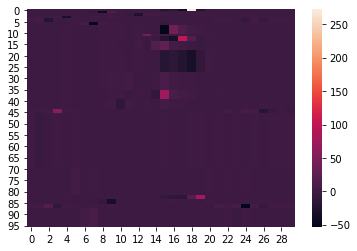

transformed distmats:


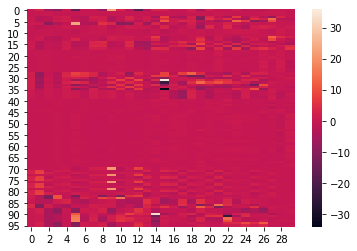

original distmat:


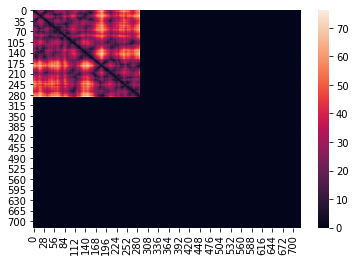

inverse transformed distmat:


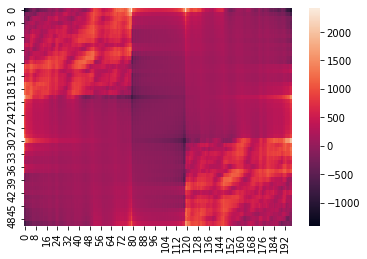

In [138]:
'''print("align")
print(aligns[0])
print("voxels example: pKa of side chain")
sns.heatmap(voxels[0,:,:,0])
plt.show()
print("voxels example: gap matrix")
sns.heatmap(voxels[0,:,:,12])
plt.show()
print("distmat for globins align (101M)")
sns.heatmap(distmats[0])
plt.show()'''

print("transformed voxels:")
sns.heatmap(transformed_voxels)
plt.show()
print("transformed distmats:")
sns.heatmap(transformed_distmats)
plt.show()

print('original distmat:')
sns.heatmap(arrayListForTest[0])
plt.show()
print('inverse transformed distmat:')
recovered_distmats = inverse_transform_y(transformed_distmats, scalerY, ndpcaY, FFT = False)
recovered_distmat_list = []
temp = np.vsplit(recovered_distmats, recovered_distmats.shape[0])
for distmat in temp:
    recovered_distmat_list.append(distmat[0,:,:])
unFFT_distmats = inverseFourierDistmats(recovered_distmat_list)
sns.heatmap(unFFT_distmats[0])
plt.show()